Clustering NBA Players

In NBA media coverage, sports reporters usually focus on a handful of players and paint stories of how unique these players' stats are. With our data science hats on, we can't help but feel a slight sense of skepticism to how different the players are from one another. Let's see how we can use data science to explore that thread further.

Let's look at the dataset of player performance from the 2013-2014 season.

Here are some selected columns:

    player -- name of the player
    pos -- the position of the player
    g -- number of games the player was in
    pts -- total points the player scored
    fg. -- field goal percentage
    ft. -- free throw percentage


In [1]:
import pandas as pd
import numpy as np

nba = pd.read_csv("nba_2013.csv")
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


In [2]:
point_guards = nba[nba['pos'] == 'PG']

Points Per Game

While our dataset doesn't come with Points Per Game values, we can easily calculate those using each player's total points (pts) and the number of games (g) they played. Let's take advantage of pandas' ability to multiply and divide columns to create the Points Per Game ppg column by dividing the pts and g columns.

In [3]:
point_guards['ppg'] = point_guards['pts'] / point_guards['g']

# Sanity check, make sure ppg = pts/g
point_guards[['pts', 'g', 'ppg']].head(5)

C:\Users\kknagara\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,pts,g,ppg
24,930,71,13.098592
29,150,20,7.500000
30,660,79,8.354430
38,666,72,9.250000
50,378,55,6.872727


In [4]:
#Assist Turnover Ratio- Assist Turnover Ratio, which is calculated by dividing total assists (ast) by total turnovers (tov):
point_guards = point_guards[point_guards['tov'] != 0]
point_guards['atr'] = point_guards['ast'] / point_guards['tov']

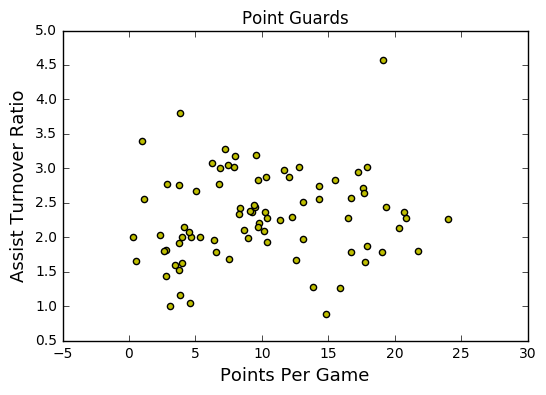

In [6]:
#Visualizing the Point Guards -Use matplotlib to create a scatter plot with Points Per Game (ppg) on the X axis and Assist Turnover Ratio (atr) on the Y axis.
import matplotlib.pyplot as plt
plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

Clustering players

There seem to be 5 general regions, or clusters, that the point guards fall into (with a few outliers of course!). We can use a technique called clustering to segment all of the point guards into groups of alike players. While regression and other supervised machine learning techniques work well when we have a clear metric we want to optimize for and lots of pre-labelled data, we need to instead use unsupervised machine learning techniques to explore the structure within a data set that doesn't have a clear value to optimize.

There are multiple ways of clustering data but here we will focus on centroid based clustering for this lesson. Centroid based clustering works well when the clusters resemble circles with centers (or centroids). The centroid represent the arithmetic mean of all of the data points in that cluster.

K-Means Clustering is a popular centroid-based clustering algorithm that we will use. The K in K-Means refers to the number of clusters we want to segment our data into. The key part with K-Means (and most unsupervised machine learning techniques) is that we have to specify what k is. There are advantages and disadvantages to this, but one advantage is that we can pick the k that makes the most sense for our use case. We'll set k to 5 since we want K-Means to segment our data into 5 clusters.

The Algorithm

Setup K-Means is an iterative algorithm that switches between recalculating the centroid of each cluster and the players that belong to that cluster. To start, select 5 players at random and assign their coordinates as the initial centroids of the just created clusters.

Step 1 (Assign Points to Clusters) For each player, calculate the Euclidean distance between that player's coordinates, or values for atr & ppg, and each of the centroids' coordinates. Assign the player to the cluster whose centroid is the closest to, or has the lowest Euclidean distance to, the player's values.

Step 2 (Update New Centroids of the Clusters) For each cluster, compute the new centroid by calculating the arithmetic mean of all of the points (players) in that cluster. We calculate the arithmetic mean by taking the average of all of the X values (atr) and the average of all of the Y values (ppg) of the points in that cluster.

Iterate Repeat steps 1 & 2 until the clusters are no longer moving and have converged.

In [7]:
num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]

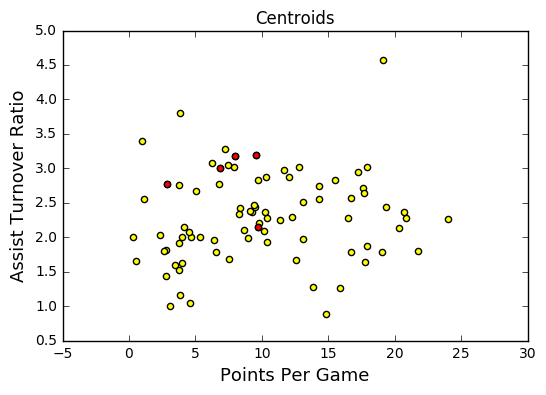

In [8]:
#Visualize Centroids -Let's plot the centroids, in addition to the point_guards, so we can see where the randomly chosen centroids started out.
plt.scatter(point_guards['ppg'], point_guards['atr'], c='yellow')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

In [9]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)

In [10]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print(calculate_distance(q, p))

2.2360679775


In [11]:
def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1
    
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)
        
        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id 
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)   

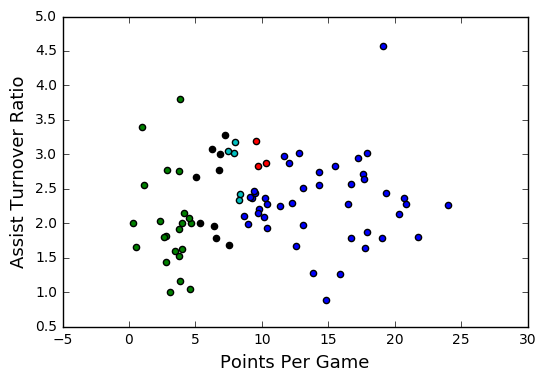

In [12]:
# Visualizing clusters
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

In [13]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    # 0..1...2...3...4
    for cluster_id in range(0, num_clusters):
        # Finish the logic
        return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)

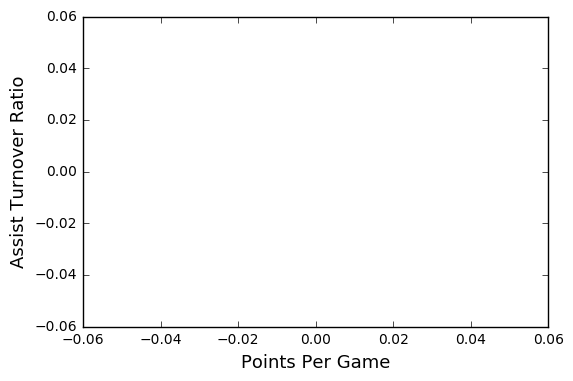

In [14]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

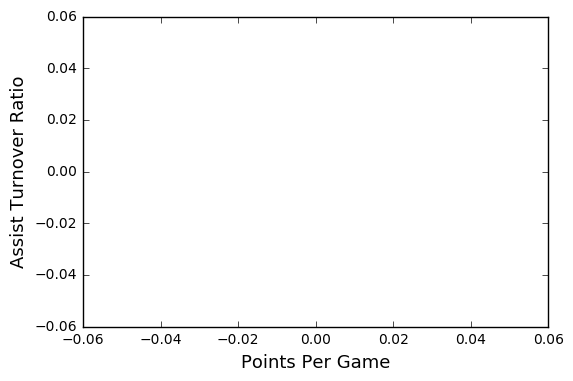

In [15]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

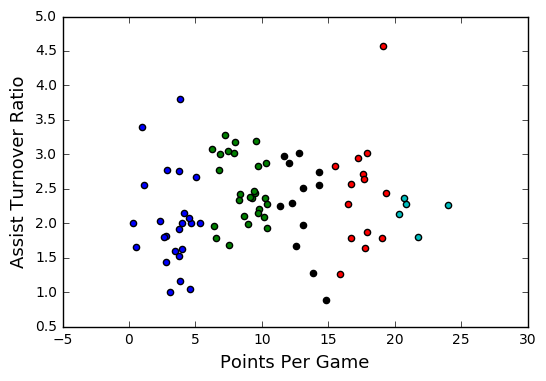

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)